In [1]:
# reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# import packages
import re
import numpy as np
import pandas as pd
import time
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
import nltk
nltk.download("stopwords") 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevingoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Import Dataset
df = pd.read_csv("all_articles.csv").drop_duplicates(["article","date"])
df.head()

,Unnamed: 0,article,datetime,date
0,769,['Scant information has emerged since reports ...,"Apr 19, 2016 08:22am",2016-04-19
1,768,['Maryland-based platform specialist Intrexon ...,"Apr 19, 2016 09:41am",2016-04-19
2,943,['Researchers at Carnegie Mellon University ha...,"Aug 30, 2016 12:04am",2016-08-30
3,767,['With billions of dollars and a decades-long ...,"Sep 1, 2016 04:21am",2016-09-01
4,1034,"[""Bayer is teaming up with Finland's DelSiTech...","Oct 3, 2016 11:44am",2016-10-03


In [ ]:
len(df)

In [7]:
# Convert to list
data = df.article.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['[Scant information has emerged since reports began to circulate late last '
 'week that Swiss life sciences company Lonza Group ($LONN) was making a run '
 'at Catalent ($CTLT), a U.S.-based drug delevoper., In a report that cited '
 'unnamed sources, Reuters said the two were in talks. The news sent Catalent '
 'shares soaring 12%, boosting its market capitalization to almost $4 '
 'billion., Those same sources, however, said the two sides had been, so far, '
 'unable to agree on a price for Catalent. Lonza has been in an acquisition '
 'mode in recent years, snapping up smaller bioscience companies in the U.S. '
 'Back in 2011, Lonza shelled out $1.4 billion for chemical maker Arch '
 'Chemicals., Both companies declined to comment on the rumors., If Lonza, '
 'which has a market capitalization of about $9 billion, were to reach terms '
 'for Catalent it would give the Swiss company a bigger reach in the life '
 'sciences arena and the capability to produce an expanded line of mole

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['scant', 'information', 'has', 'emerged', 'since', 'reports', 'began', 'to', 'circulate', 'late', 'last', 'week', 'that', 'swiss', 'life', 'sciences', 'company', 'lonza', 'group', 'lonn', 'was', 'making', 'run', 'at', 'catalent', 'ctlt', 'based', 'drug', 'delevoper', 'in', 'report', 'that', 'cited', 'unnamed', 'sources', 'reuters', 'said', 'the', 'two', 'were', 'in', 'talks', 'the', 'news', 'sent', 'catalent', 'shares', 'soaring', 'boosting', 'its', 'market', 'capitalization', 'to', 'almost', 'billion', 'those', 'same', 'sources', 'however', 'said', 'the', 'two', 'sides', 'had', 'been', 'so', 'far', 'unable', 'to', 'agree', 'on', 'price', 'for', 'catalent', 'lonza', 'has', 'been', 'in', 'an', 'acquisition', 'mode', 'in', 'recent', 'years', 'snapping', 'up', 'smaller', 'bioscience', 'companies', 'in', 'the', 'back', 'in', 'lonza', 'shelled', 'out', 'billion', 'for', 'chemical', 'maker', 'arch', 'chemicals', 'both', 'companies', 'declined', 'to', 'comment', 'on', 'the', 'rumors', 'if',

In [24]:
# # Build the bigram and trigram models
# start_time = time.time()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])
print("--- %s seconds ---" % (time.time() - start_time))

['scant', 'information', 'has', 'emerged', 'since', 'reports', 'began', 'to', 'circulate', 'late', 'last', 'week', 'that', 'swiss', 'life_sciences', 'company', 'lonza', 'group', 'lonn', 'was', 'making', 'run', 'at', 'catalent', 'ctlt', 'based', 'drug', 'delevoper', 'in', 'report', 'that', 'cited', 'unnamed', 'sources', 'reuters', 'said', 'the', 'two', 'were', 'in', 'talks', 'the', 'news', 'sent', 'catalent', 'shares', 'soaring', 'boosting', 'its', 'market', 'capitalization', 'to', 'almost', 'billion', 'those', 'same', 'sources', 'however', 'said', 'the', 'two', 'sides', 'had', 'been', 'so_far', 'unable', 'to', 'agree', 'on', 'price', 'for', 'catalent', 'lonza', 'has', 'been', 'in', 'an', 'acquisition', 'mode', 'in', 'recent', 'years', 'snapping', 'up', 'smaller', 'bioscience', 'companies', 'in', 'the', 'back', 'in', 'lonza', 'shelled_out', 'billion', 'for', 'chemical', 'maker', 'arch', 'chemicals', 'both', 'companies', 'declined', 'to', 'comment', 'on', 'the', 'rumors', 'if', 'lonza', 

In [25]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
start_time = time.time()
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00017571449279785156 seconds ---


In [26]:
start_time = time.time()

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])
print("--- %s seconds ---" % (time.time() - start_time))

[['scant', 'information', 'emerge', 'report', 'begin', 'circulate', 'late', 'last', 'week', 'swiss', 'company', 'make', 'run', 'catalent', 'base', 'drug', 'report', 'cite', 'unnamed', 'source', 'reuter', 'say', 'talk', 'news', 'send', 'catalent', 'share', 'soar', 'boost', 'market', 'capitalization', 'almost', 'source', 'however', 'say', 'side', 'far', 'unable', 'agree', 'price', 'catalent', 'lonza', 'acquisition', 'mode', 'recent', 'year', 'snap', 'small', 'bioscience', 'company', 'lonza', 'shell', 'chemical', 'maker', 'arch', 'chemical', 'company', 'decline', 'comment', 'rumor', 'lonza', 'market', 'capitalization', 'reach', 'term', 'catalent', 'give', 'swiss', 'company', 'big', 'reach', 'arena', 'capability', 'produce', 'expand', 'line', 'molecule', 'ingredient', 'drug', 'delivery', 'news', 'agency', 'say', 'base', 'catalent', 'facility', 'globally', 'publicly', 'trade', 'acquire', 'cardinal', 'health', 'cah', 'private_equity', 'firm', 'blackstone', 'group', 'reuter', 'story']]
--- 21

In [27]:
start_time = time.time()
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
print("--- %s seconds ---" % (time.time() - start_time))

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 5), (18, 2), (19, 1), (20, 1), (21, 1), (22, 4), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 2), (55, 2), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)]]
--- 0.16214513778686523 seconds ---


In [63]:
start_time = time.time()

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# documentation at https://radimrehurek.com/gensim/models/ldamodel.html

print("--- %s seconds ---" % (time.time() - start_time))

--- 4.1416850090026855 seconds ---


In [64]:
# Print the top 10 Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.097*"cancer" + 0.073*"astella" + 0.059*"roche" + 0.051*"tumor" + '
  '0.036*"inhibitor" + 0.030*"spark" + 0.029*"survival" + 0.028*"progression" '
  '+ 0.026*"bristol_myer" + 0.021*"cell"'),
 (1,
  '0.038*"vaccine" + 0.032*"company" + 0.024*"say" + 0.022*"covid" + '
  '0.021*"year" + 0.018*"pfizer" + 0.017*"dose" + 0.010*"supply" + '
  '0.009*"deal" + 0.009*"moderna"'),
 (2,
  '0.051*"manufacturing" + 0.038*"facility" + 0.037*"cell" + 0.027*"site" + '
  '0.025*"production" + 0.022*"therapy" + 0.022*"plant" + 0.021*"manufacture" '
  '+ 0.020*"company" + 0.019*"say"'),
 (3,
  '0.031*"neck" + 0.029*"engage" + 0.018*"hpv" + 0.015*"gardasil" + '
  '0.014*"cancer" + 0.013*"persistent" + 0.012*"boy" + 0.010*"merck" + '
  '0.010*"hpv_vaccination" + 0.010*"safety_concern"'),
 (4,
  '0.037*"patient" + 0.035*"drug" + 0.026*"say" + 0.019*"therapy" + '
  '0.019*"treatment" + 0.012*"novartis" + 0.011*"company" + 0.011*"year" + '
  '0.010*"approval" + 0.009*"first"'),
 (5,
  '0.066*"german"

In [65]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.439988496839236

Coherence Score:  0.44359364306600885


In [66]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.152927  0.348584       1        1  31.150046
10    -0.010669  0.342743       2        1  18.137180
4     -0.267214  0.286953       3        1  16.181145
13     0.084560  0.333320       4        1  15.192144
2      0.311009  0.298267       5        1   8.316209
11    -0.365844  0.098317       6        1   7.938472
0      0.341910 -0.209897       7        1   0.990901
12     0.187321 -0.054172       8        1   0.814246
8     -0.087976 -0.300074       9        1   0.474578
5     -0.161221 -0.206192      10        1   0.286295
7      0.118607 -0.229418      11        1   0.218467
3      0.010494 -0.214431      12        1   0.186898
6     -0.012391 -0.167169      13        1   0.096154
14     0.003701 -0.162202      14        1   0.013615
9      0.000639 -0.164630      15        1   0.003650, topic_info=               Term         Freq        Total Category  logprob  loglift
1003         pfizer  1541.000000  1541.000000  Default  30.0000  30.0000
717         vaccine  5446.000000  5446.000000  Default  29.0000  29.0000
660   manufacturing  1246.000000  1246.000000  Default  28.0000  28.0000
139         patient  1478.000000  1478.000000  Default  27.0000  27.0000
546            cell  1071.000000  1071.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
25             drug     0.000769  2322.518663  Topic15  -9.3412  -4.7021
26           emerge     0.000769   100.396539  Topic15  -9.3412  -1.5608
27           expand     0.000769   282.063338  Topic15  -9.3412  -2.5938
28         facility     0.000769   750.893487  Topic15  -9.3412  -3.5730
29              far     0.000769   207.244908  Topic15  -9.3412  -2.2856

[826 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1919      3  0.995489     abbvie
78        1  0.359392     accord
78        2  0.139324     accord
78        3  0.022165     accord
78        4  0.188404     accord
...     ...       ...        ...
76        4  0.206780       year
76        5  0.043691       year
874       4  0.989349      young
3022      6  0.969658     zejula
5485      3  0.997688  zolgensma

[1161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 5, 14, 3, 12, 1, 13, 9, 6, 8, 4, 7, 15, 10])

In [45]:
# The compute_coherence_values() (see below) trains multiple LDA models and provides the models 
# and their corresponding coherence scores.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        #model_list.append(model)
        #coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #coherence_values.append(coherencemodel.get_coherence())
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [46]:
# Can take a long time to run.
start_time = time.time()

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

print("--- %s seconds ---" % (time.time() - start_time))

--- 38.81070804595947 seconds ---


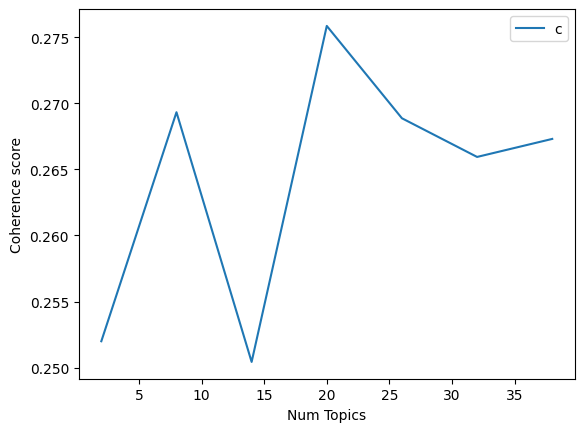

In [47]:
# Show the visualization chart
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2376
Num Topics = 8  has Coherence Value of 0.2573
Num Topics = 14  has Coherence Value of 0.2526
Num Topics = 20  has Coherence Value of 0.2746
Num Topics = 26  has Coherence Value of 0.2601
Num Topics = 32  has Coherence Value of 0.2633
Num Topics = 38  has Coherence Value of 0.2634


In [67]:
results=[]
for result in lda_model[corpus]:
    testdict={}
    for topic, score in result[0]:
        testdict[score]=topic
    results.append(testdict[max(testdict)])
results

[1,
 10,
 10,
 4,
 10,
 10,
 10,
 11,
 10,
 4,
 10,
 10,
 4,
 1,
 10,
 1,
 13,
 1,
 13,
 10,
 13,
 2,
 1,
 11,
 10,
 1,
 10,
 10,
 10,
 13,
 1,
 10,
 13,
 10,
 1,
 10,
 10,
 13,
 12,
 13,
 13,
 10,
 13,
 10,
 13,
 10,
 13,
 13,
 13,
 10,
 13,
 10,
 1,
 13,
 1,
 1,
 13,
 13,
 13,
 10,
 10,
 10,
 1,
 1,
 1,
 10,
 10,
 12,
 10,
 1,
 13,
 10,
 13,
 10,
 11,
 11,
 11,
 10,
 10,
 10,
 11,
 11,
 1,
 13,
 10,
 11,
 4,
 4,
 11,
 10,
 10,
 1,
 1,
 4,
 11,
 10,
 1,
 10,
 10,
 11,
 1,
 13,
 10,
 11,
 1,
 10,
 1,
 11,
 11,
 4,
 13,
 10,
 11,
 13,
 2,
 10,
 10,
 1,
 10,
 13,
 2,
 10,
 10,
 13,
 10,
 11,
 11,
 13,
 10,
 1,
 10,
 13,
 13,
 13,
 10,
 1,
 11,
 10,
 10,
 13,
 10,
 11,
 1,
 4,
 1,
 10,
 13,
 1,
 1,
 4,
 13,
 13,
 13,
 2,
 1,
 10,
 10,
 10,
 2,
 10,
 10,
 1,
 10,
 4,
 11,
 10,
 13,
 1,
 2,
 13,
 13,
 13,
 10,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 4,
 10,
 10,
 10,
 1,
 1,
 1,
 10,
 13,
 1,
 1,
 11,
 13,
 1,
 1,
 1,
 4,
 10,
 10,
 10,
 13,
 4,
 10,
 13,
 13,
 1,
 13,
 10,
 1,
 10,
 10,
 

In [68]:
set(results)

{1, 2, 4, 10, 11, 12, 13}

In [72]:
df['topic_raw']=results
conditions=[
    df['topic_raw']==1,
    df['topic_raw']==2,
    df['topic_raw']==4,
    df['topic_raw']==10,
    df['topic_raw']==11,
    df['topic_raw']==12,
    df['topic_raw']==13
]
values=[
    1,
    5,
    3,
    2,
    6,
    7,
    4
]
df['topic']=np.select(conditions,values,np.nan)

In [73]:
for topic in sorted(df.topic.unique()):
    df[f'Topic {int(topic)}']=np.where(df['topic']==topic,1,0)
    df[f'Topic {int(topic)} rolling']=df[f'Topic {int(topic)}'].cumsum()
df

,Unnamed: 0,article,datetime,date,topic_raw,topic,Topic 1,Topic 1 rolling,Topic 2,Topic 2 rolling,Topic 3,Topic 3 rolling,Topic 4,Topic 4 rolling,Topic 5,Topic 5 rolling,Topic 6,Topic 6 rolling,Topic 7,Topic 7 rolling
0,769,['Scant information has emerged since reports ...,"Apr 19, 2016 08:22am",2016-04-19,1,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,768,['Maryland-based platform specialist Intrexon ...,"Apr 19, 2016 09:41am",2016-04-19,10,2.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
2,943,['Researchers at Carnegie Mellon University ha...,"Aug 30, 2016 12:04am",2016-08-30,10,2.0,0,1,1,2,0,0,0,0,0,0,0,0,0,0
3,767,['With billions of dollars and a decades-long ...,"Sep 1, 2016 04:21am",2016-09-01,4,3.0,0,1,0,2,1,1,0,0,0,0,0,0,0,0
4,1034,"[""Bayer is teaming up with Finland's DelSiTech...","Oct 3, 2016 11:44am",2016-10-03,10,2.0,0,1,1,3,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,1019,['Riding on the growth of long-acting antiretr...,"Sep 28, 2023 09:00am",2023-09-28,4,3.0,0,381,0,205,1,168,0,129,0,99,0,53,0,2
1055,961,['As bluebird bio’s pricey gene therapy launch...,"Sep 28, 2023 09:29am",2023-09-28,1,1.0,1,382,0,205,0,168,0,129,0,99,0,53,0,2
1056,957,"['Dato-DXd, the TROP2-targeted antibody-drug c...","Sep 29, 2023 10:45am",2023-09-29,4,3.0,0,382,0,205,1,169,0,129,0,99,0,53,0,2
1057,770,['After a former human resources officer blew ...,"Sep 29, 2023 11:35am",2023-09-29,11,6.0,0,382,0,205,0,169,0,129,0,99,1,54,0,2


/var/folders/2q/m02shclj04v8g_2vqn0pwr3c0000gp/T/ipykernel_11577/2865496122.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling=rolling.fillna(method='ffill')


<Axes: >

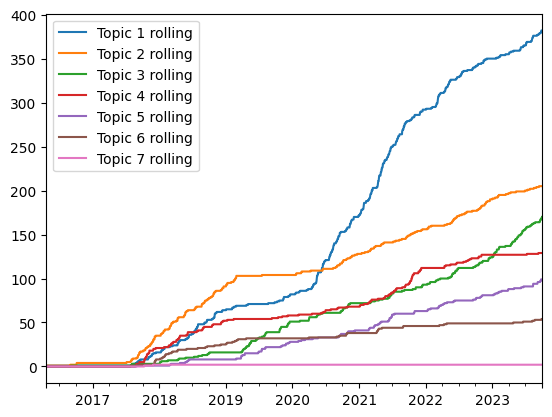

In [74]:
columns = [i for i in df.columns if 'rolling' in i] + ['date']
rolling=df[columns]
rolling=rolling.drop_duplicates('date',keep='last')
rolling.set_index('date',inplace=True)
idx=pd.date_range(rolling.index[0],rolling.index[-1])
rolling.index=pd.DatetimeIndex(rolling.index)
rolling=rolling.reindex(idx,fill_value=np.nan)
rolling=rolling.fillna(method='ffill')
rolling.plot()

/var/folders/2q/m02shclj04v8g_2vqn0pwr3c0000gp/T/ipykernel_11577/40227122.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ma=ma.fillna(method='ffill')


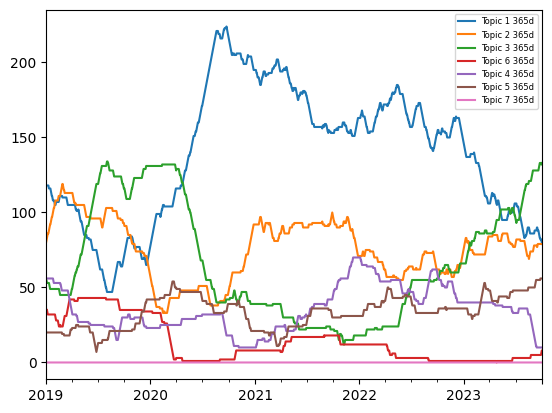

In [75]:
columns=[i for i in df.columns if 'Topic' in i and 'rolling' not in i]+['date']
ma=df[columns]
ma=ma.drop_duplicates('date',keep='last')
ma.set_index('date',inplace=True)
idx=pd.date_range(ma.index[0],ma.index[-1])
ma.index=pd.DatetimeIndex(ma.index)
ma=ma.reindex(idx,fill_value=np.nan)
ma=ma.fillna(method='ffill')
for topic in df.topic.unique():
    ma[f'Topic {int(topic)} 365d']=ma[f'Topic {int(topic)}'].rolling(365).sum()
    ma.drop(columns=f'Topic {int(topic)}',inplace=True)
ma['2019':].plot()
plt.legend(fontsize = 6)